In [ ]:
# === Step 1: Import Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix


In [ ]:
# === Step 2: Load & Preprocess Dataset ===
data = pd.read_csv("/content/dataset_full (1).csv")
print("Dataset shape:", data.shape)
print(data.head())

data = data.dropna().drop_duplicates()
boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params', 'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index', 'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)

numerical_columns = [col for col in data.columns if col not in boolean_columns]
scaler_standard = StandardScaler()
data[numerical_columns] = scaler_standard.fit_transform(data[numerical_columns])
scaler_minmax = MinMaxScaler()
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])

joblib.dump(scaler_standard, "scaler_standard.pkl")
joblib.dump(scaler_minmax, "scaler_minmax.pkl")
data.to_csv("newphishdata.csv", index=False)


Dataset shape: (88647, 112)
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0            3               0                  0              1   
1            5               0                  1              3   
2            2               0                  0              1   
3            4               0                  2              5   
4            2               0                  0              0   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                     0              0           0            0   
1                     0              3           0            2   
2                     0              0           0            0   
3                     0              0           0            0   
4                     0              0           0            0   

   qty_exclamation_url  qty_space_url  ...  qty_ip_resolved  qty_nameservers  \
0                    0              0  ...                1                2   


In [ ]:
# === Step 3: Train-Test Split ===
X = data.drop(columns=['phishing'])
y = data['phishing']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Reshape data for LSTM input (samples, timesteps, features)
X_train_lstm = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])


In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class NeuralFieldAttention(Layer):
    def __init__(self, timesteps=10, lambda_strength=0.1, **kwargs):
        super(NeuralFieldAttention, self).__init__(**kwargs)
        self.timesteps = timesteps
        self.lambda_strength = lambda_strength

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='interaction_kernel'
        )
        super().build(input_shape)

    def call(self, inputs):
        I = inputs  # [batch, seq_len, feature_dim]
        u = tf.zeros_like(I)

        # Precompute mean over sequence to avoid dynamic operations
        I_mean = tf.reduce_mean(I, axis=1, keepdims=True)
        delta = tf.reduce_mean(tf.abs(I - I_mean), axis=-1, keepdims=True)
        delta = tf.tile(delta, [1, 1, I.shape[-1]])

        for _ in range(self.timesteps):
            interaction = tf.matmul(I, self.kernel)
            activation = tf.nn.relu(u)
            u = u + (-u + interaction + I + self.lambda_strength * delta)

        attention_scores = tf.nn.softmax(u, axis=1)
        attended_output = tf.reduce_sum(attention_scores * inputs, axis=1)

        return attended_output

    def get_config(self):
        config = super().get_config()
        config.update({
            "timesteps": self.timesteps,
            "lambda_strength": self.lambda_strength
        })
        return config


In [ ]:
# === Step 4: Build LSTM Model (with Attention) ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Reshape

lstm_model = Sequential()

# Recommended: use an Input layer to avoid warnings
lstm_model.add(Input(shape=(1, X_train.shape[1])))

# LSTM layers
lstm_model.add(LSTM(units=64, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=32, return_sequences=False))  # Output: (batch_size, 32)
lstm_model.add(Dropout(0.2))

# === FIX: Add Dense(64) before Reshape so it becomes (batch_size, 64) ===
lstm_model.add(Dense(64, activation='relu'))  # Now we can safely reshape to (8, 8)
lstm_model.add(Reshape((8, 8)))

# Neural Field Attention layer
lstm_model.add(NeuralFieldAttention(timesteps=5, lambda_strength=0.2))

# Fully connected layers after attention
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.2))

# Output layer
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile model
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        45,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neural_field_attention          │ (None, 8)              │            64 │
│ (NeuralFieldAttention)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,121 (270.00 KB)

 Trainable params: 69,121 (270.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# === Step 5: Define Callbacks ===
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

epoch_times = []

def on_epoch_begin(epoch, logs=None):
    global epoch_start_time
    epoch_start_time = time.time()

def on_epoch_end(epoch, logs=None):
    epoch_times.append(time.time() - epoch_start_time)
    print(f"Epoch {epoch+1} Time: {epoch_times[-1]:.2f}s")

time_callback = keras.callbacks.LambdaCallback(on_epoch_begin=on_epoch_begin, on_epoch_end=on_epoch_end)


In [ ]:
history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test_lstm, y_test),
    callbacks=[early_stopping, time_callback],
    verbose=1
)


Epoch 1/50
1088/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9895 - Precision: 0.9312 - Recall: 0.9344 - accuracy: 0.9530 - loss: 0.1228Epoch 1 Time: 12.66s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - AUC: 0.9895 - Precision: 0.9312 - Recall: 0.9344 - accuracy: 0.9530 - loss: 0.1229 - val_AUC: 0.9893 - val_Precision: 0.9214 - val_Recall: 0.9439 - val_accuracy: 0.9522 - val_loss: 0.1248
Epoch 2/50
1088/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9884 - Precision: 0.9253 - Recall: 0.9321 - accuracy: 0.9498 - loss: 0.1277Epoch 2 Time: 10.63s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - AUC: 0.9884 - Precision: 0.9253 - Recall: 0.9321 - accuracy: 0.9498 - loss: 0.1277 - val_AUC: 0.9894 - val_Precision: 0.9392 - val_Recall: 0.9224 - val_accuracy: 0.9520 - val_loss: 0.1243
Epoch 3/50
1084/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9891 - Precision: 0.9297 - Recall: 0.9316 - accuracy: 0.9516 - loss: 0.1250Epoch 3 Time: 19.52s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - AUC: 0

In [ ]:
# === Step 7: Evaluate Model ===
y_pred = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# FAR & FRR
fp, fn = conf_matrix[0][1], conf_matrix[1][0]
tn, tp = conf_matrix[0][0], conf_matrix[1][1]
far = fp / (fp + tn)
frr = fn / (fn + tp)
print("\nFAR:", round(far, 4))
print("FRR:", round(frr, 4))


546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Metrics:
Accuracy: 0.9576
Precision: 0.9405
Recall: 0.9382
AUC: 0.9531
Confusion Matrix:
[[10981   362]
 [  377  5722]]

FAR: 0.0319
FRR: 0.0618


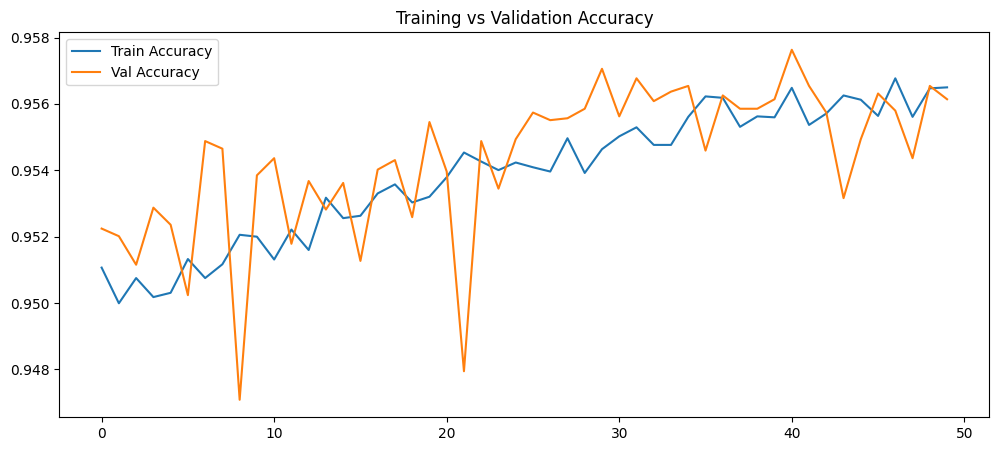

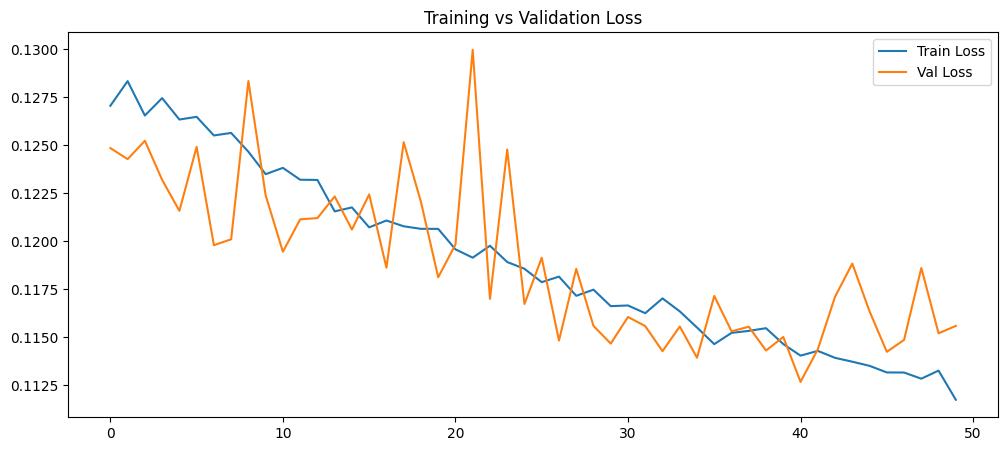

In [ ]:
# === Step 8: Save History and Plot Curves ===
np.save("model_history_lstm.npy", history.history)

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [ ]:
lstm_model.export("phish_model_lstm_attention")


Saved artifact at 'phish_model_lstm_attention'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 111), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137451546526160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451546528656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451546528464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451546529040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451546525968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451546531728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451546532112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451546534032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451546533648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451546532688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451546

In [ ]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model phish_model_lstm_attention tfjs_phish_model


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-14 12:54:10.230182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744635250.264434   18625 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

In [ ]:
# Zip the converted model directory
!zip -r tfjs_phish_model.zip tfjs_phish_model


  adding: tfjs_phish_model/ (stored 0%)
  adding: tfjs_phish_model/model.json (deflated 95%)
  adding: tfjs_phish_model/group1-shard1of1.bin (deflated 7%)


In [ ]:
from google.colab import files
files.download("tfjs_phish_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>